In [1]:
import astropy.io.fits
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.chebyshev import chebval
import scipy.linalg
from constants import HIGH_ERROR, LEFT_MARGIN
from scipy.stats import median_abs_deviation

In [2]:
hdul = astropy.io.fits.open("bkdsub_rateints_ERS_NGTS10_2022_seg_038.fits")

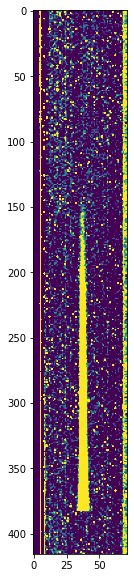

In [3]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.imshow(np.mean(hdul[1].data, axis=0), vmin=0, vmax=1)

38
(416, 16) (416, 16)


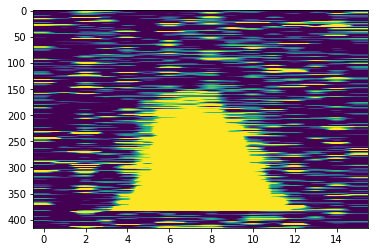

In [4]:
#cutout = np.mean(hdul[1].data, axis=0)[:,10:]
data = hdul["SCI"].data[0]
data[:, 0:10] = 0
profile = np.sum(data, axis=0)
trace_loc = np.argmax(profile)
#print()
print(trace_loc)

cutout = data[:,trace_loc-8:trace_loc+8] 
error = hdul["ERR"].data[0, :, trace_loc-8:trace_loc+8]
print(cutout.shape, error.shape)
profile = np.sum(cutout, axis=0)
plt.imshow(cutout, aspect='auto', vmin=0, vmax=1)
#print(cutout.shape)


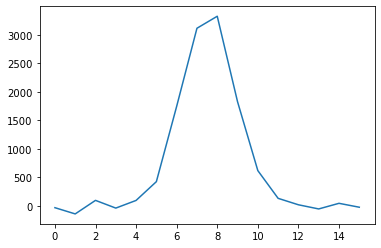

In [5]:
plt.plot(profile)

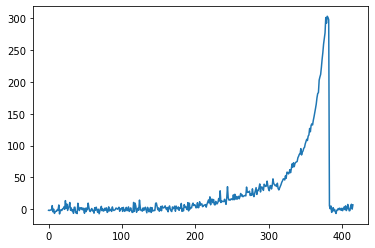

In [6]:
spectrum = np.sum(cutout, axis=1)
plt.plot(spectrum)

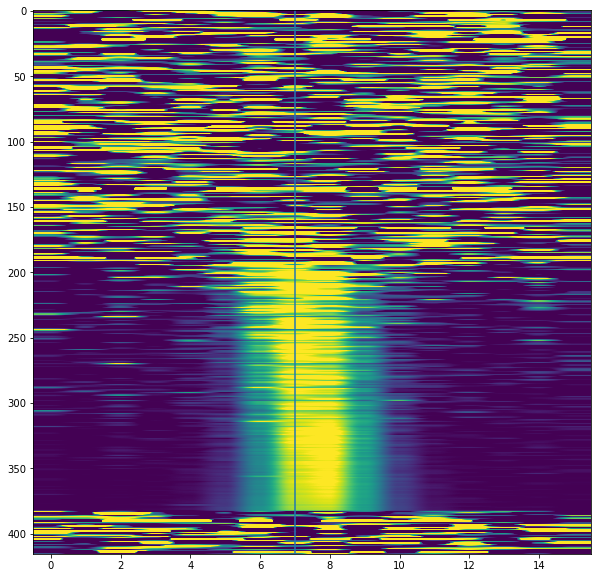

In [7]:
profile = cutout / spectrum[:,np.newaxis]
%matplotlib qt
plt.figure(figsize=(10,10))
plt.imshow(profile, vmin=0, vmax=0.3, aspect='auto')
plt.axvline(7)
plt.show()

(-0.2, 0.5)

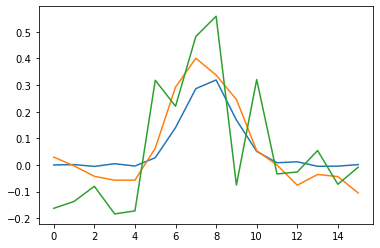

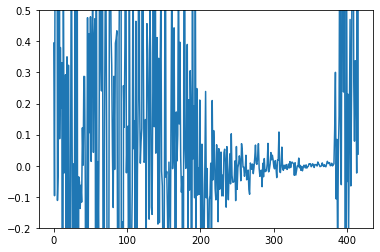

In [8]:
%matplotlib inline
plt.plot(profile[360])
plt.plot(profile[250])
plt.plot(profile[200])
plt.figure()
plt.plot(profile[:,12])
plt.ylim(-0.2, 0.5)

In [9]:
print(cutout.shape, spectrum.shape)

(416, 16) (416,)


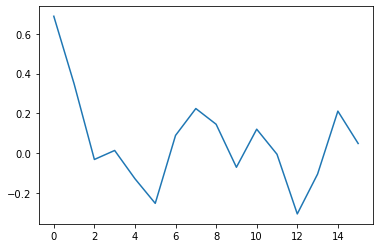

In [10]:
plt.plot(profile[28])

(0.0, 0.7)

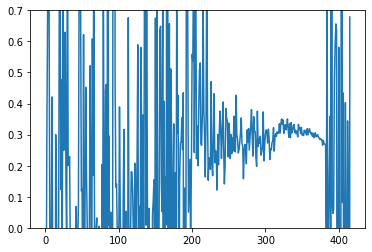

In [11]:
plt.plot(profile[:,8])
plt.ylim(0, 0.7)

In [74]:
def fit_spectrum(image_row, spectrum, weights, num_ord=4):
    cols = np.arange(len(spectrum))
    xs = (cols - np.mean(cols))/len(cols) * 2
    A = []
    for o in range(num_ord):
        cheby_coeffs = np.zeros(o + 1)
        cheby_coeffs[o] = 1
        cheby = chebval(xs, cheby_coeffs)
        A.append(spectrum * cheby)

    A = np.array(A).T
    Aw = A * np.sqrt(weights[:, np.newaxis])
    Bw = image_row * np.sqrt(weights)
    coeffs, residuals, rank, s = scipy.linalg.lstsq(Aw, Bw)    
    predicted = Aw.dot(coeffs)
    smoothed_profile = chebval(xs, coeffs)
    
#     print(residuals)
#     plt.plot(predicted)
#     plt.plot(Bw)
#     plt.figure()
    return smoothed_profile


#smoothed_profile = fit_spectrum(cutout[:,8], spectrum, weights=1/error[:,8]**2)
#plt.plot(smoothed_profile)

In [75]:
def horne_iteration(image, bkd, spectrum, M, V, badpix, flat_err, read_noise, N, sigma=5):
    #N is the number of groups used
    #print(image.shape, bkd.shape, spectrum.shape, V.shape, badpix.shape)
    V[image == 0] = HIGH_ERROR**2 
    smoothed_profile = np.zeros(image.shape)
    cols = np.arange(image.shape[1])
    
    for r in range(image.shape[0]):
        weights = 1.0/V[r] 
        weights[~M[r]] = 0
        smoothed = fit_spectrum(image[r], spectrum, weights)
        smoothed_profile[r] = smoothed
                            
    smoothed_profile[smoothed_profile < 0] = 0
    smoothed_profile[image == 0] = 0
    smoothed_profile /= np.sum(smoothed_profile, axis=0)[np.newaxis, :]
    
    model_image = smoothed_profile * spectrum
    #plt.plot(V[8])
    
    l = np.arccosh(1 + np.abs(model_image + bkd) / read_noise**2 / 2)
    V = 1 / (read_noise**-2 * np.exp(l) * (-N*np.exp(-l*N) + np.exp(2*l)*N + np.exp(l-l*N)*(2+N) - np.exp(l)*(2+N)) / (np.exp(l) - 1)**3 / (np.exp(-l*N) + np.exp(l)))
    #print(flat_err)
    plt.plot(V[8])
    V += ((model_image + bkd) * flat_err)**2
    plt.plot(V[8])
    plt.figure()
    #V = read_noise**2 + np.abs(model_image + bkd)
    #plt.plot(V[8])
    #plt.figure()
    V[badpix] = HIGH_ERROR**2

    #plt.figure(0, figsize=(18,3))
    #plt.clf() 
    #plt.imshow(badpix, aspect='auto')
    #plt.show()

    z_scores = (image - model_image)/np.sqrt(V)
    M = np.array(z_scores**2 < sigma**2, dtype=bool)
    V[~M] = HIGH_ERROR**2
    spectrum = np.sum(smoothed_profile * image / V, axis=0) / np.sum(smoothed_profile**2 / V, axis=0)
    spectrum_variance = np.sum(smoothed_profile, axis=0) / np.sum(smoothed_profile**2 / V, axis=0)

    return spectrum, spectrum_variance, V, smoothed_profile, M, z_scores

In [76]:
# %matplotlib qt
# no_badpix = np.zeros(cutout.shape, dtype=bool)
# N = 299 - 5

# cutout = hdul["SCI"].data[0,:,trace_loc-8:trace_loc+8].T
# simple_spectrum = np.sum(cutout, axis=0)

# spectrum, spectrum_variance, V, smoothed_profile, M, z_scores = horne_iteration(
#     cutout,
#     hdul["BKD"].data[0,:,trace_loc-8:trace_loc+8].T,
#     simple_spectrum,
#     hdul["ERR"].data[0,:,trace_loc-8:trace_loc+8].T**2,
#     no_badpix.T,
#     hdul[0].header["RDNOISE"] * hdul[0].header["GAINCF"]
# )

# plt.imshow(z_scores, vmin=-5, vmax=5, aspect='auto')

In [77]:
def optimal_extract(image, bkd, badpix, flat_err, read_noise, max_iter=10):
    cutout = image
    spectrum = np.sum(image, axis=0)
    
    V = np.ones(cutout.shape)
    M = np.ones(cutout.shape, dtype=bool)
    counter = 0
    
    while True:        
        spectrum, spectrum_variance, V, P, new_M, z_scores = horne_iteration(cutout, bkd, spectrum, M, V, badpix, flat_err, read_noise, 299-5, sigma=10)
        plt.figure(figsize=(16,16))
        plt.imshow(z_scores, vmin=-10, vmax=10)
        plt.figure()
        
        print("Iter, num bad:", counter, np.sum(~new_M))
        if np.all(M == new_M) or counter > max_iter: break
        M = new_M
        counter += 1

    return spectrum, spectrum_variance, z_scores, P, M, V



Iter, num bad: 0 68
Iter, num bad: 1 61
Iter, num bad: 2 64
Iter, num bad: 3 64
2.7733140261466622


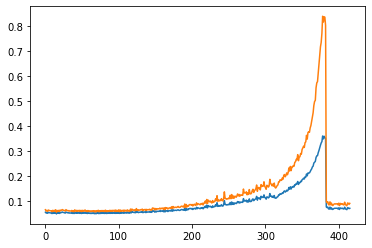

<Figure size 432x288 with 0 Axes>

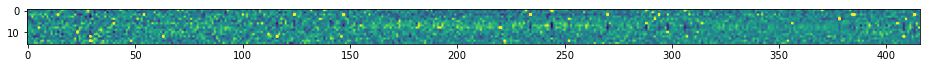

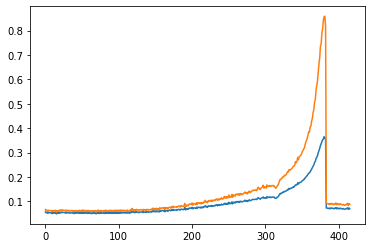

<Figure size 432x288 with 0 Axes>

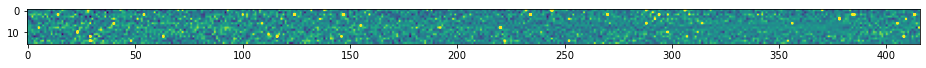

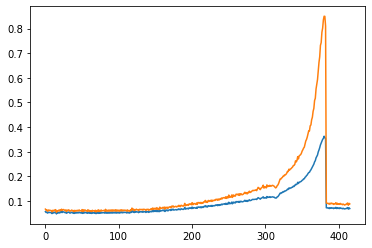

<Figure size 432x288 with 0 Axes>

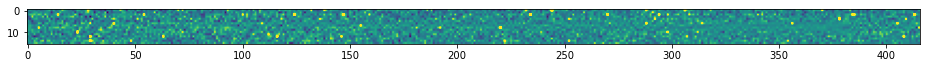

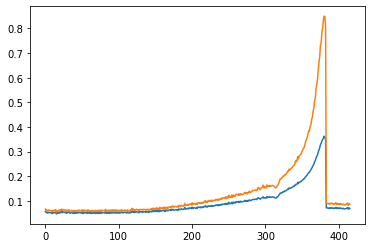

<Figure size 432x288 with 0 Axes>

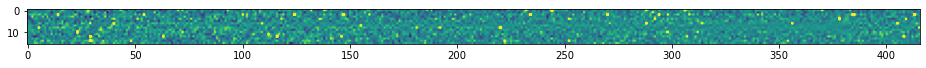

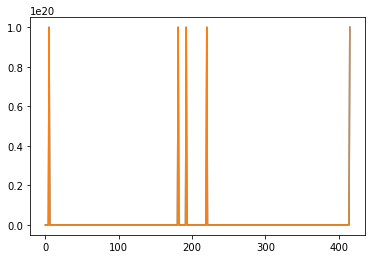

In [78]:
%matplotlib inline
cutout = hdul["SCI"].data[0,:,trace_loc-8:trace_loc+8].T
no_badpix = np.zeros(cutout.shape, dtype=bool)
spectrum, spectrum_variance, z_scores, P, M, V = optimal_extract(cutout,
                hdul["BKD"].data[0,:,trace_loc-8:trace_loc+8].T,
                no_badpix,
                hdul["FLATERR"].data[:,trace_loc-8:trace_loc+8].T,
                hdul[0].header["RDNOISE"] * hdul[0].header["GAINCF"]
               )
print(np.std(z_scores[M]))

plt.plot(V[8])
plt.plot(V[8])

Iter, num bad: 0 241
Iter, num bad: 1 173
Iter, num bad: 2 166
Iter, num bad: 3 159
Iter, num bad: 4 157
Iter, num bad: 5 159
Iter, num bad: 6 158
Iter, num bad: 7 158
3.0263123011780033


/home/stanley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()
/home/stanley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/home/stanley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expl

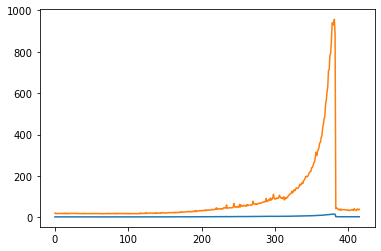

<Figure size 432x288 with 0 Axes>

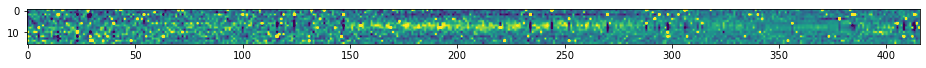

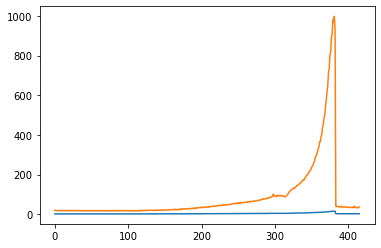

<Figure size 432x288 with 0 Axes>

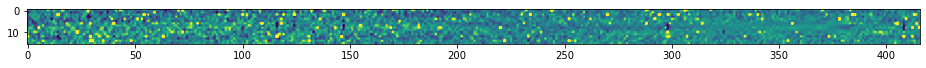

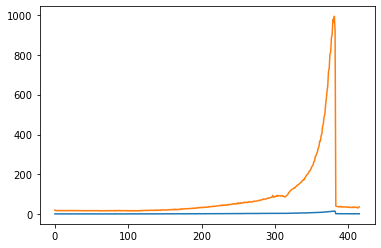

<Figure size 432x288 with 0 Axes>

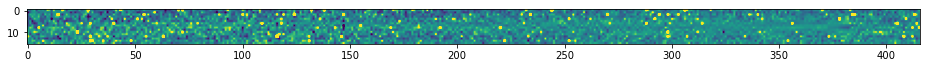

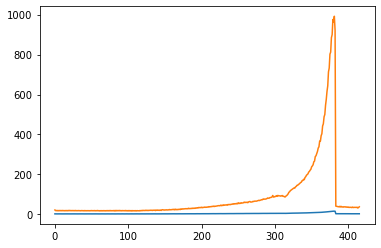

<Figure size 432x288 with 0 Axes>

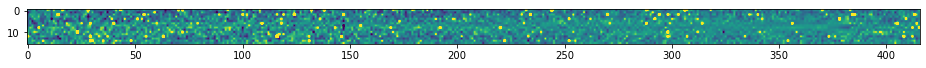

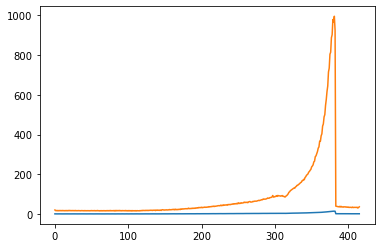

<Figure size 432x288 with 0 Axes>

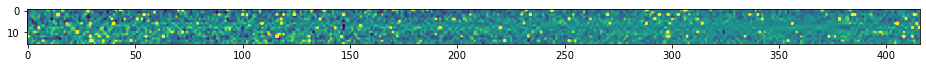

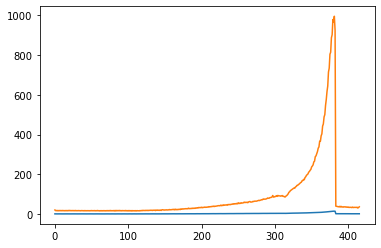

<Figure size 432x288 with 0 Axes>

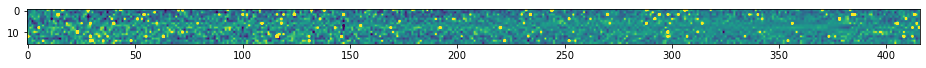

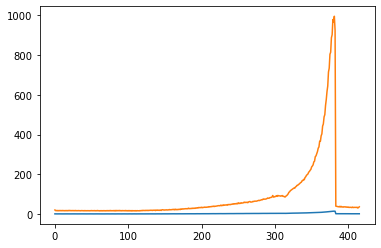

<Figure size 432x288 with 0 Axes>

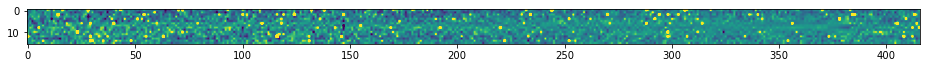

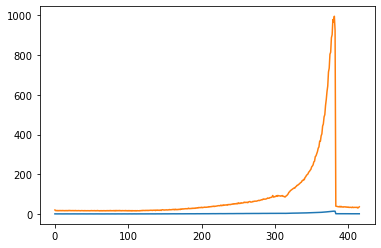

<Figure size 432x288 with 0 Axes>

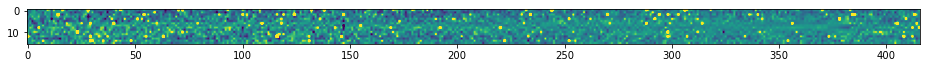

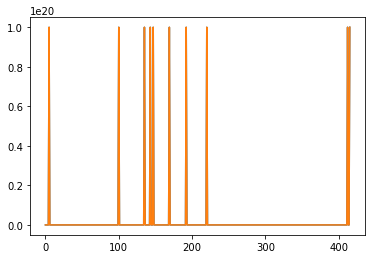

In [57]:
#Try summing everything
%matplotlib inline
cutout = np.sum(hdul["SCI"].data, axis=0)[:,trace_loc-8:trace_loc+8].T
bkd_cutout = np.sum(hdul["BKD"].data, axis=0)[:,trace_loc-8:trace_loc+8].T


no_badpix = np.zeros(cutout.shape, dtype=bool)
spectrum, spectrum_variance, z_scores, P, M, V = optimal_extract(cutout,
                bkd_cutout,
                no_badpix,
                hdul["FLATERR"].data[:,trace_loc-8:trace_loc+8].T,
                hdul[0].header["RDNOISE"] * hdul[0].header["GAINCF"]
               )
print(np.std(z_scores[M]))

plt.plot(V[8])
plt.plot(V[8])

2.994445644947463


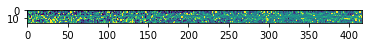

In [28]:
%matplotlib qt
print(np.std(z_scores[M]))
plt.imshow(z_scores, vmin=-5, vmax=5)

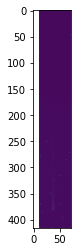

In [29]:
%matplotlib qt
plt.imshow(hdul["ERR"].data[0], vmin=0, vmax=10)
plt.show()

(0.0, 0.1)

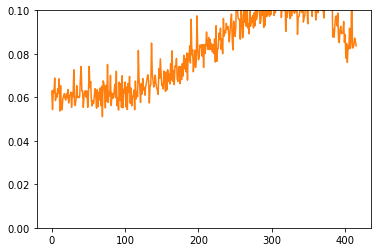

In [30]:
plt.plot(V[4])
plt.plot(hdul["ERR"].data[0,:,trace_loc-8:trace_loc+8].T[4]**2)
plt.ylim(0, 0.1)

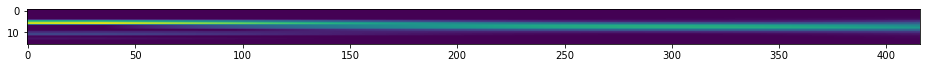

In [73]:
%matplotlib inline
plt.figure(figsize=(16,16))
plt.imshow(P)

(200.0, 390.0)

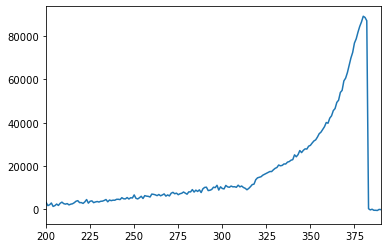

In [21]:
%matplotlib inline
plt.plot(spectrum * 294)
#plt.plot(spectrum_variance * 294**2)
plt.xlim(200, 390)

2.763274705442495


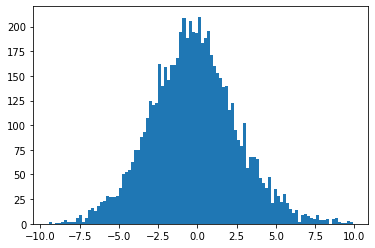

In [22]:
%matplotlib inline
print(np.std(z_scores[M]))
_ = plt.hist(z_scores[M].flatten(), bins=100)

0.8042431244103007 1.0511525840890386 0.24664662536793663
14.916242147518817


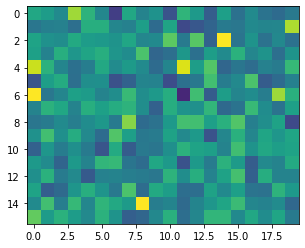

In [23]:
err_cutout = hdul["ERR"].data[0,:,trace_loc-8:trace_loc+8].T
#plt.imshow(cutout, vmin=-1, vmax=1)
print(1.48 * median_abs_deviation(cutout[:,40:60].flatten()), np.std(cutout[:,40:60]), np.mean(err_cutout[:,40:60]))
print(np.median(hdul["BKD"].data[0,:,trace_loc-8:trace_loc+8].T[:,40:60]))

#print()
plt.figure()
plt.imshow(cutout[:,40:60], vmin=-3, vmax=3)

1.405725620231501
18.394664547515156


<Figure size 432x288 with 0 Axes>

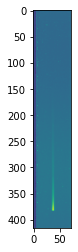

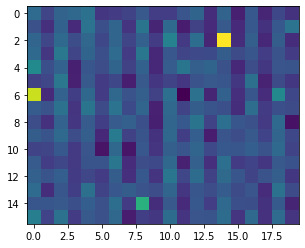

<Figure size 432x288 with 0 Axes>

In [24]:
hdul = astropy.io.fits.open("ERS_NGTS10_2022_seg_038.fits")
signal = (hdul[1].data[:,-1] - hdul[1].data[:,0])[0]
plt.imshow(hdul[1].data[0,-1])
plt.figure()
raw_cutout = signal[:,trace_loc-8:trace_loc+8].T[:,40:60]
plt.imshow(raw_cutout)

print(5.5 * 1.48*median_abs_deviation(raw_cutout.flatten()) / 299)
print(5.5 * np.median(raw_cutout) / 299)
plt.figure()

KeyError: "Extension 'ERR' not found."

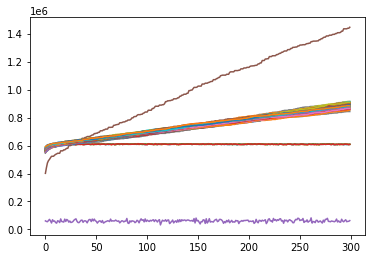

In [25]:
N = 299 - 5
plt.plot(hdul["SCI"].data[0,:,trace_loc] * N)
#plt.figure()
plt.plot(hdul["ERR"].data[0,:,trace_loc]**2 * N**2)

In [26]:
hdul[0].header["RDNOISE"] * hdul[0].header["GAINCF"]

19.7472

In [27]:
profile = fit_spectrum(cutout[:,8], spectrum, weights=1/error[:,8]**2)
plt.plot(profile)

ValueError: operands could not be broadcast together with shapes (16,) (416,) 

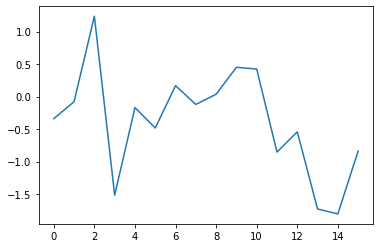

In [28]:
plt.plot(cutout[:,8])

0.9586084556579589
14.913425 0.58750474


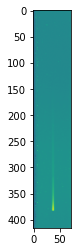

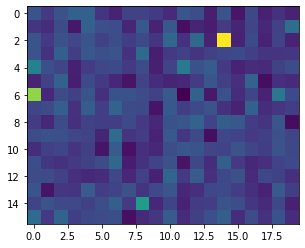

In [29]:
#See JWST pipeline product
hdul = astropy.io.fits.open("ERS_NGTS10_2022_seg_038_rateints.fits")
plt.imshow(hdul[1].data[0])

cutout = hdul["SCI"].data[0,:,trace_loc-8:trace_loc+8].T[:,40:60] * 0.159 * 5.5
err_cutout = hdul["ERR"].data[0,:,trace_loc-8:trace_loc+8].T[:,40:60] * 0.159 * 5.5
print(1.48*median_abs_deviation(cutout.flatten()))
plt.figure()
plt.imshow(cutout)

print(np.median(cutout), np.median(err_cutout))
#print(np.median(hdul["ERR"].data[0,:,trace_loc-8:trace_loc+8].T[:,40:60]))
#print(np.median(hdul["SCI"].data[0,:,trace_loc-8:trace_loc+8].T[:,40:60]))

0.810309559056116
13.081734892212072 0.2157097364016105


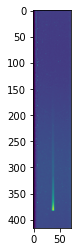

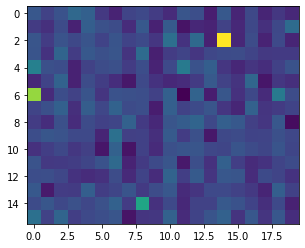

In [106]:
#See my product
hdul = astropy.io.fits.open("rateints_ERS_NGTS10_2022_seg_038.fits")
plt.imshow(hdul[1].data[0])

cutout = hdul["SCI"].data[0,:,trace_loc-8:trace_loc+8].T[:,40:60] * 0.159 * 5.5
err_cutout = hdul["ERR"].data[0,:,trace_loc-8:trace_loc+8].T[:,40:60] * 0.159 * 5.5
print(1.48*median_abs_deviation(cutout.flatten()))
plt.figure()
plt.imshow(cutout)

print(np.median(cutout), np.median(err_cutout))
#print(np.median(hdul["ERR"].data[0,:,trace_loc-8:trace_loc+8].T[:,40:60]))
#print(np.median(hdul["SCI"].data[0,:,trace_loc-8:trace_loc+8].T[:,40:60]))

30 46


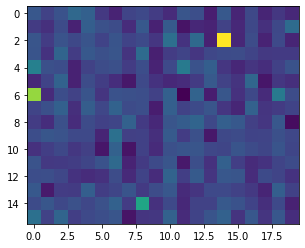

In [135]:
print(trace_loc-8, trace_loc+8)
plt.imshow(hdul["SCI"].data[0,40:60,30:46].T)

13.98401775587821 0.21703134039748476


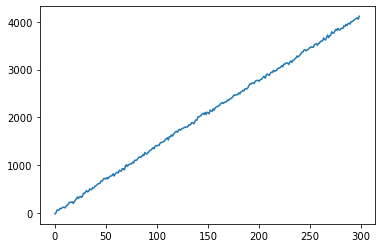

In [130]:
#Simulate some data
measured_slopes = []
for i in range(100):
    N = 299
    R = 19
    arrivals = np.random.normal(14, np.sqrt(14), N)
    data = np.cumsum(arrivals)
    data += np.random.normal(0, R, len(data))
    xs = np.arange(N)
    coeffs = np.polyfit(xs, data, 1)
    measured_slopes.append(coeffs[0])
    #print(coeffs[0])
    if i == 0:
        plt.plot(data)
print(np.mean(measured_slopes), np.std(measured_slopes))

In [137]:
hdul = astropy.io.fits.open("ERS_NGTS10_2022_seg_038_rateints.fits")
DN_per_sec_to_e_per_grp = 0.159 * 5.5
print(np.median(hdul["SCI"].data[0,40:60,30:46]) * DN_per_sec_to_e_per_grp)
print(np.median(hdul["ERR"].data[0,40:60,30:46]) * DN_per_sec_to_e_per_grp)

14.913426847457886
0.587504752457142


(44, 416, 72)
(44, 416, 72)


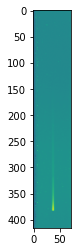

In [34]:
hdul = astropy.io.fits.open("ERS_NGTS10_2022_seg_038_rateints.fits")
print(hdul["SCI"].data.shape)
print(hdul["ERR"].data.shape)
plt.imshow(hdul[1].data[0])


In [70]:
y = 367
x = 38
DN_per_sec_to_e_per_grp = 0.159 * 5.5

their_hdul = astropy.io.fits.open("../test_jwst_pipeline/ERS_NGTS10_2022_seg_038_rateints.fits")
print(their_hdul["SCI"].data[0,y,x] * DN_per_sec_to_e_per_grp, their_hdul["ERR"].data[0,y,x] * DN_per_sec_to_e_per_grp)

my_hdul = astropy.io.fits.open("rateints_ERS_NGTS10_2022_seg_038.fits")
print(my_hdul["SCI"].data[0,y,x], my_hdul["ERR"].data[0,y,x])

%matplotlib qt
plt.imshow(their_hdul["ERR"].data[0] * DN_per_sec_to_e_per_grp / my_hdul["ERR"].data[0], vmin=0, vmax=3)
plt.show()

75.00659597396852 1.3331208431124688
74.98457682861061 0.7122446297298606


In [60]:
(1.333/0.7116)**2

3.509040817532381

In [67]:
est_var = 75/299 + 12*19**2/(300**3 - 300)
print(np.sqrt(est_var))

0.5009955754580255


In [64]:
(1.333/0.5)

2.666

In [65]:
2.666*3

7.997999999999999